# Load Dependencies

Loading required python packages.

In [79]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score


# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import GridSearchCV, cross_val_score

#metrics, procssing and model selection
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
#Setting Plot figure size
sns.set(rc={'figure.figsize':(12.8,11.27)})

# Data Collection

As kaggle already provided us with data in the form of csv files, all we have to do is load them into dataframes.

In [80]:
#loading csv's
train=pd.read_csv('train.csv')
test=pd.read_csv('test_with_no_labels.csv')

In [3]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
train.shape

(15819, 3)

In [5]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [6]:
test.shape

(10546, 2)

# Exploratory Data Analysis

In [7]:
train.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [9]:
#Evaluating the skewness
train.skew()

sentiment   -0.683959
tweetid     -0.008471
dtype: float64

In [10]:
#Evaluating the kurtosis
train.kurtosis()

sentiment    0.122976
tweetid     -1.193356
dtype: float64

## Distribution values  of labels

Text(0.5, 1.0, 'Distribution of sentiment labels')

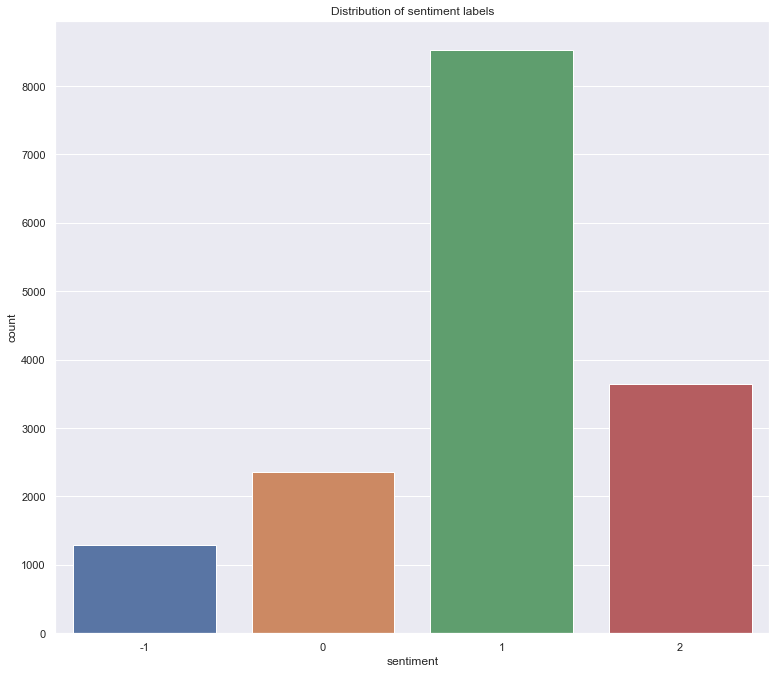

In [11]:
sns.countplot(x=train['sentiment'])
plt.title('Distribution of sentiment labels')

In [12]:
# checking the distribution
train['sentiment'].value_counts()/train.shape[0]

 1    0.539225
 2    0.230103
 0    0.148745
-1    0.081927
Name: sentiment, dtype: float64

## Number of Unique values:

In [13]:
train['sentiment'].unique()
train['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

## Converting the Sentiment Labels from numbers to text

Changing the Sentiment numbers to legiable text for better transparancy on what they mean, so we can correlate and understand the data better

In [14]:
# Making a copy of the train data since we will be making changes to the dataset
train_df = train.copy()

In [15]:
train_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in train_df['sentiment']]

Text(0.5, 1.0, 'Message count per sentiment')

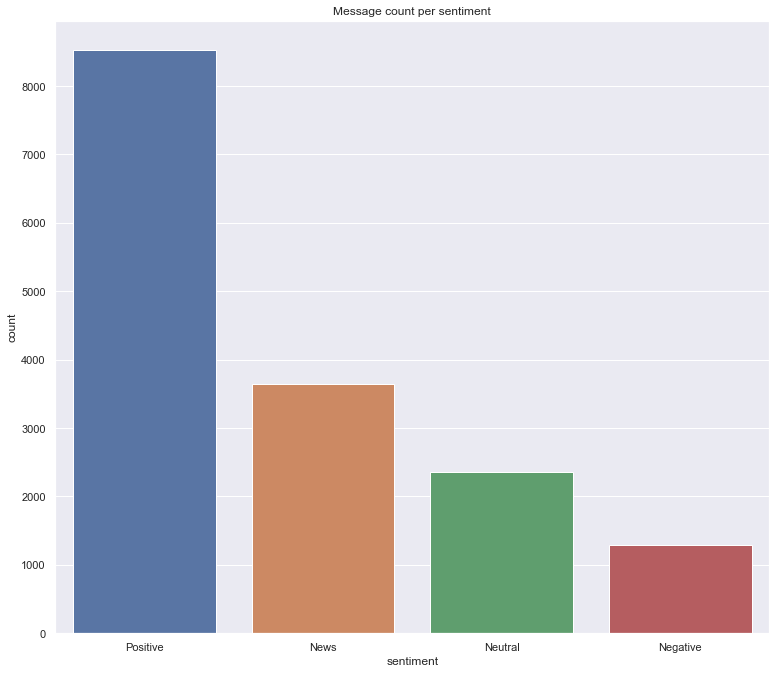

In [16]:
sns.countplot(x=train_df['sentiment'])
plt.title('Message count per sentiment')

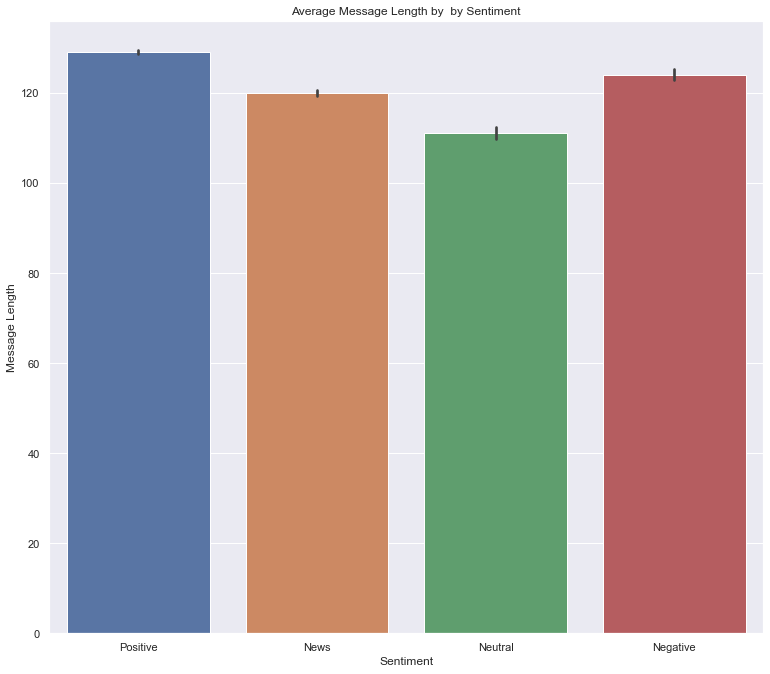

In [17]:
sns.barplot(x='sentiment', y=train_df['message'].apply(len) ,data = train_df)
plt.ylabel('Message Length')
plt.xlabel('Sentiment')
plt.title('Average Message Length by  by Sentiment')
plt.show()

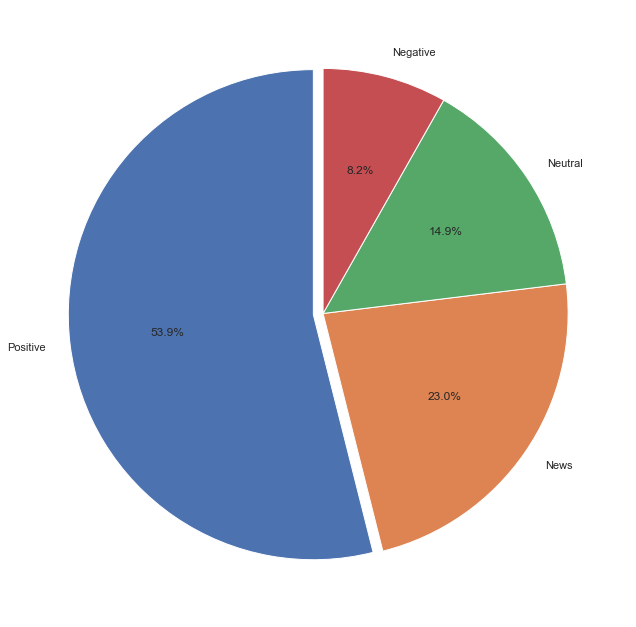

In [18]:
#numerical distribution
values = train_df['sentiment'].value_counts()/train_df.shape[0]
labels = (train_df['sentiment'].value_counts()/train_df.shape[0]).index
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0))
plt.show()

### Counting user names that are repeated in tweets

Here we are looking for Twitter accounts/users that are commonly brought up in messages

In [19]:
train_df['users'] = [''.join(re.findall(r'@\w{,}', line)) if '@' in line else np.nan for line in train_df.message]
counts = train_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [20]:
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


In [21]:
repeated_tags_rate = round(counts['message'][counts['message'] > 1].sum() * 100/len(counts['message']), 0)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

86.0 percent of the data are from repeated tags


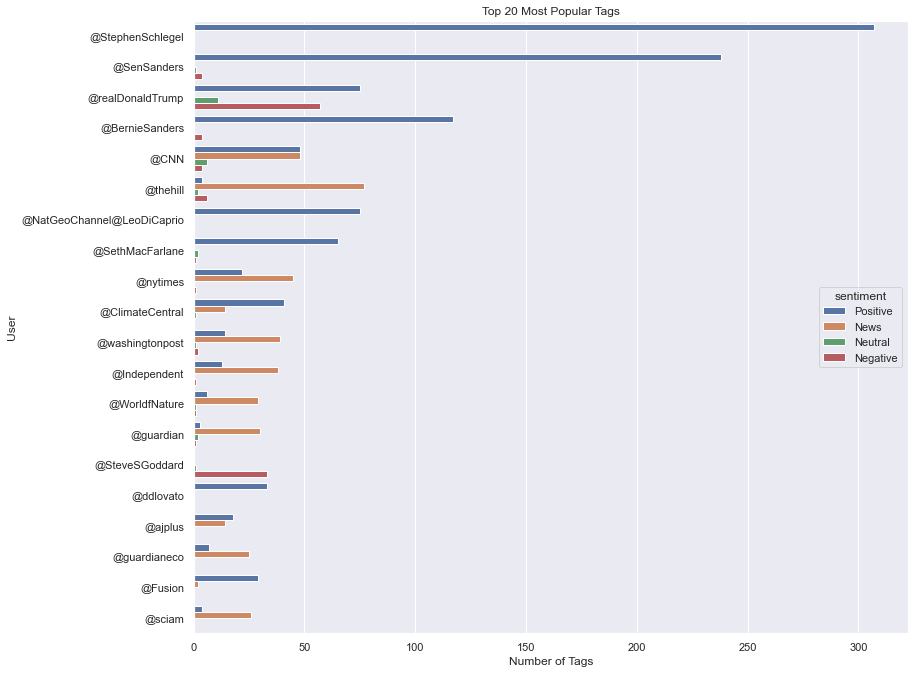

In [22]:
sns.countplot(y="users", hue="sentiment", data=train_df,
              order=train_df.users.value_counts().iloc[:20].index) 
plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()

## Creating a Word Cloud

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(tweet for tweet in train_df.message)
print ("There are {} words in the combination of all tweets.".format(len(text)))

There are 1976222 words in the combination of all tweets.


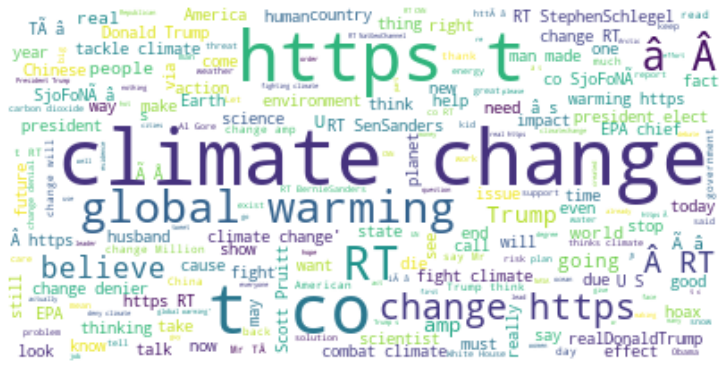

In [24]:
# Creating the wordcloud 
wordcloud = WordCloud(background_color="white").generate(text)

# Displaying the wordcloud:
# using matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data Cleaning

Kaggle tries to provide us with clean data but it's always a good idea to check for ourselves. We check for null and empty values.

In [25]:
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

none of our columns contain any null or empty values.

In [26]:
i=0
for x in train.columns:
    if '' in sorted(train[x].unique()):
        i+=1
print('The data contains '+str(i)+' empty values over all columns')

The data contains 0 empty values over all columns


# Pre-processing

### Removing noise

First convert all text data into lowercase

In [27]:
# Lower case all words to remove noise from Capital words. Capital words may be seen as different from lower case words
train_df['message'] = train_df['message'].str.lower()
test['message'] = test['message'].str.lower()

#### Contractions

In [28]:
# Dictionary of contracted words
contractions = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"wasn't": "was not",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we'll":"we will",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
}

Now let's replace the contracted words by their expanded alternatives.

In [29]:
# Replace contracted words with full word
train_df['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) 
                       for raw in train_df['message']]
test['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) 
                       for raw in test['message']]

#### Incomplete words

In [30]:
# Replace shortened words with full words
short = {' BD ': ' Big Deal ',
 ' abt ':' about ',
 ' ab ': ' about ',
 ' fav ': ' favourite ',
 ' fab ': ' fabulous ',
 ' smh ': ' shaking my head ',
 ' u ': ' you ',
 ' c ': ' see ',
 ' anon ': ' anonymous ',
 ' ac ': ' aircon ',
 ' a/c ': ' aircon ',
 ' yo ':' year old ',
 ' n ':' and ',
 ' nd ':' and ',
 ' 2 ': ' to ',
 ' w ': ' with ',
 ' w/o ': ' without ',
 ' r ': ' are ',
 ' rip ':' rest in peace ',
 ' 4 ' : ' for ',
' BF ': ' Boyfriend ',
' BRB ': ' Be Right Back ',
' BTW ': ' By The Way ',
' GF ': ' Girlfriend ',
' HBD ': ' Happy Birthday ',
' JK ': ' Just Kidding ',
' K ':' Okay ',
' LMK ': ' Let Me Know ',
' LOL ': ' Laugh Out Loud ',
' NBC ': ' Nobody Cares Though ',
' NTW ': ' Not To Worry ',
' OTD ': ' Of The Day ',
' OOTD ': ' Outfit Of The Day ',
' QOTD ': ' Quote of the Day ',
' FOTD ': ' Find Of the Day ',
' POIDH ': ' Pictures Or It Did ntt Happen ',
' YOLO ': ' You Only Live Once ',
' AFAIK ': ' As Far As I Know ',
' DGYF ': ' Dang Girl You Fine ',
' FWIW ': ' For What It is Worth ',
' IDC ': ' I Do not Care ',
' IDK ': ' I Do not Know ',
' IIRC ': ' If I Remember Correctly ',
' IMHO ': ' In My Honest Opinion ',
' IMO ': ' In My Opinion ',
' Jelly ': ' Jealous ',
' Jellz ': ' Jealous ',
' JSYK ': ' Just So You Know ',
' LMAO ': ' Laughing My Ass Off ',
' LMFAO ': ' Laughing My Fucking Ass Off ',
' NTS ': ' Note to Self ',
' ROFL ': ' Rolling On the Floor Laughing ',
' ROFLMAO ': ' Rolling On the Floor Laughing My Ass Off ',
' SMH ': ' Shaking My Head ',
' TBH ': ' To Be Honest ',
' TL;DR ':  ' Too Long; Did not Read ',
' TLDR ':  ' Too Long; Did not Read ',
' YGTR ': ' You Got That Right ',
' AYKMWTS ': ' Are You Kidding Me With This Shit ',
' BAMF ': ' Bad Ass Mother Fucker ',
' FFS ': ' For Fuck Sake ',
' FML ': ' Fuck My Life ',
' HYFR ': ' Hell Yeah Fucking Right ',
' IDGAF ': ' I Do not Give A Fuck ',
' NFW ': ' No Fucking Way ',
' PITA ': ' Pain In The Ass ',
' POS ': ' Piece of Shit ',
' SOL ': ' Shit Outta Luck ',         
' STFU ': ' Shut the Fuck Up ',
' TF ': ' The Fuck ',
' WTF ': ' What The Fuck ',
' BFN ': ' Bye For Now ',
' CU ': ' See You ',
' IC ': ' I see ',
' CYL ': ' See You Later ',
' GTG ': ' Got to Go ',
' OMW ': ' On My Way ',
' RN ': ' Right Now ',
' TTYL ': ' Talk To You Later ',
' TYT ': ' Take Your time ',
' CC ': ' Carbon Copy ',
' CX ': ' Correction ',
' DM ': ' Direct Message ',
' FB ': ' Facebook ',
' FBF ': ' Flash-Back Friday ',
' FF ': ' Follow Friday ',
' HT ': ' Tipping my hat ',
' H/T ': ' Tipping my hat ',
' IG ': ' Instagram ',
' Insta ': ' Instagram ',
' MT ':' Modified Tweet ',
' OH ': ' Overheard ',
' PRT ': ' Partial Retweet ',
' RT ': ' Retweet ',
'rt ' : ' retweet ',
' SO ':' Shout Out ',
' S/O ': ' Shout Out ',
' TBT ': ' Throw-Back Thursday ',
' AWOL ': ' Away While Online ',
' BFF ': ' Best Friend Forever ',
' NSFW ': ' Not Safe For Work ',
' OG ': ' Original Gangster ',
' PSA ': ' Public Service Announcement ',
' PDA ': ' Public Display of Affection ',        
' HA ':' laugh ',
' MYOB ': ' Mind Your Own Business ',
' NBD ': ' No Big Deal ',
' NVM ': ' Nevermind ',
' Obv ':' Obviously ',
' Obvi ':' Obviously ',
' OMG ': ' Oh My God ',
' Pls ': ' Please ',
' Plz ': ' Please ',
' Q ': ' Question ', 
' QQ ': ' Quick Question ',
' RLY ': ' Really ',
' SRLSY ': ' Seriously ',
' TMI ': ' Too Much Information ',
' TY ': ' Thank You, ',
' TYVM ': ' Thank You Very Much ',
' YW ': ' You are Welcome ',
' FOMO ': ' Fear Of Missing Out ',
' FTFY ': ' Fixed This For You ',
' FTW ': ' For The Win ',
' FYA ': ' For Your Amusement ',
' FYE ': ' For Your Entertainment ',
' GTI ': ' Going Through It ',
' HTH ': ' Here to Help ',
' IRL ': ' In Real Life ',
' nt  ': ' not ',
' ICYMI ': ' In Case You Missed It ',
' ICYWW ': ' In Case You Were Wondering '}
short = dict((key.lower(), value.lower()) for key,value in short.items())

Now let's replace the shortened words by their full alternatives.

In [31]:
# Replacing shortened words with full words
for word in short.keys():
    train_df['message'] = train_df['message'].apply(lambda x: re.sub(word,short[word],x))
for word in short.keys():
    test['message'] = test['message'].apply(lambda x: re.sub(word,short[word],x))

### Removing Stop words

In [32]:
stopwordlist = stopwords.words('english')
stopwordlist = set(stopwordlist)
def removing_stopwords(data):
    return " ".join([word for word in str(data).split() if word not in stopwordlist])
train_df['message'] = train_df['message'].apply(lambda x: removing_stopwords(x))
test['message'] = test['message'].apply(lambda x: removing_stopwords(x))

### Removing emojis

In [33]:
def remove_emoji(words):
    emojis = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    return emojis.sub(r'', words)
train_df['message'] = train_df['message'].apply(lambda x: remove_emoji(x))
test['message'] = test['message'].apply(lambda x: remove_emoji(x))

### Removing URLs

In [34]:
def removing_URL(data):
    """This function take a string as an input and removes any url that are present in that string"""
    
    return re.sub(r"http\S+", "", data) 
train_df['message'] = train_df['message'].apply(lambda x: removing_URL(x))
test['message'] = test['message'].apply(lambda x: removing_URL(x))

### Removing punctuations

In [35]:
def removing_punctuations(tokenized_words):
    """This function take a string/list as an input and removes all the punctuations"""

    words = str.maketrans('', '', string.punctuation)
    return tokenized_words.translate(words)  
train_df['message'] = train_df['message'].apply(lambda x: removing_punctuations(x))
test['message'] = test['message'].apply(lambda x: removing_punctuations(x))

Removing repeating characters, numbers, other text in messages

In [36]:
def removing_repeating_char(data):
    return re.sub(r'(.)1+', r'1', data)
def removing_numbers(data):
    return re.sub('[0-9]+', '', data)
def remove_other(text):
    
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text
def clean_data(tokens):
    """Clean each word from list of tokenized words"""
    tokens = removing_repeating_char(tokens)
    tokens = removing_numbers(tokens)
    tokens = remove_other(tokens)
    return tokens
        

In [37]:
train_df['message'] = train_df['message'].apply(lambda x: clean_data(x))
test['message'] = test['message'].apply(lambda x: clean_data(x))

In [38]:
train_df.shape, test.shape

((15819, 4), (10546, 2))

In [39]:
train_df.head()

,sentiment,message,tweetid,users
0,Positive,polyscimajor epa chief think carbon dioxide ma...,625221,@mashable
1,Positive,like lack evidence anthropogenic global warming,126103,NaN
2,News,retweet rawstory researchers say three years a...,698562,@RawStory
3,Positive,todayinmaker wired pivotal year war climate ...,573736,NaN
4,Positive,retweet soynoviodetodas racist sexist climate...,466954,@SoyNovioDeTodas


### Tokenization

In [47]:
from nltk import TreebankWordTokenizer
tokeniser = TreebankWordTokenizer()

#def tokenizer_on_text(data):
#    text = [tokeniser.tokenize(word) for word in data]
#    return data
#train_df['message'] = train_df['message'].apply(lambda x: tokenizer_on_text(x))
#test['message'] = test['message'].apply(lambda x: tokenizer_on_text(x))

### Stemming

In [48]:
#def stem_text(data):
 #   text = TreebankWordTokenizer().tokenize(data)
  #  return ' '.join([SnowballStemmer('english').stem(word) for word in data])
#train_df['message'] = train_df['message'].apply(lambda x: stem_text(x))
#test['message'] = test['message'].apply(lambda x: stem_text(x))

### Lemmatization

In [49]:
lm = WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
train_df['message'] = train_df['message'].apply(lambda x: lemmatizer_on_text(x))
test['message'] = test['message'].apply(lambda x: lemmatizer_on_text(x))

In [50]:
train_df.shape, train.shape

((15819, 4), (15819, 3))

In [51]:
train_df.head()

,sentiment,message,tweetid,users
0,Positive,polyscimajor epa chief think carbon dioxide ma...,625221,@mashable
1,Positive,like lack evidence anthropogenic global warming,126103,NaN
2,News,retweet rawstory researchers say three years a...,698562,@RawStory
3,Positive,todayinmaker wired pivotal year war climate ...,573736,NaN
4,Positive,retweet soynoviodetodas racist sexist climate...,466954,@SoyNovioDeTodas


# Data resampling

This can recreated under EDA I think 

We have already identified in the (EDA) above , that data is not balanced ; that is, there are more entries in one sentiment relative to the other.

It should be expected that more and more people would be in support of the climate change belief. Given that realisation, we opted to rather upsample all the entries per sentiment to try and improve the performance of the models.

In [52]:
# import the resampling package
from sklearn.utils import resample

Due to the very large difference, especially between Positive and Negative sentiments given by the customers , we will be creating a new resampled dataframe. 

For atleast to try and balance  the data. 

In [53]:
def UpSampleData(train_df):
    '''Return dataframes with upsampled sentiment categories'''
    
    # split the data by sentiment
    sent_2 = train_df[train_df.sentiment==2]
    sent_1 = train_df[train_df.sentiment==1]
    sent_0 = train_df[train_df.sentiment==0]
    sent_3 = train_df[train_df.sentiment==-1]

    # resample the data
    sent_2 = resample(sent_2,replace=True,n_samples=7000,random_state=4)
    sent_1 = resample(sent_1,replace=True,n_samples=7000,random_state=4)
    sent_0 = resample(sent_0,replace=True,n_samples=7000,random_state=4)
    sent_3 = resample(sent_3,replace=True,n_samples=7000,random_state=4)
    
    return sent_1,sent_2,sent_0,sent_3

sent_1,sent_2,sent_0,sent_3 = UpSampleData(train)

In [54]:
clean_train_data = pd.concat([sent_1,sent_2,sent_0,sent_3])

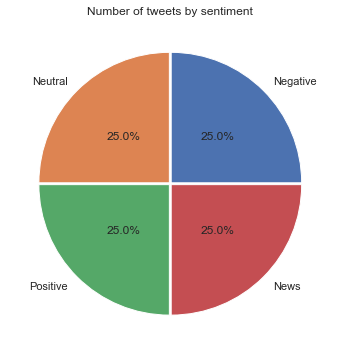

In [55]:
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(clean_train_data['sentiment'].value_counts(), autopct="%.1f%%", explode = [0.01] * 4,
        labels = ['Negative', 'Neutral', 'Positive', 'News'], pctdistance = 0.5)
plt.title("Number of tweets by sentiment");
plt.show()

# Splitting the Data

In [56]:
# split into dependent and independent arrays
X = clean_train_data['message'].values
y = clean_train_data['sentiment'].values

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (28000,)
y shape :  (28000,)


## Build Pipeline

To reduce the amount of code to use, we will be using pipelines that will both vectorize the text data and will apply the TfidfVectorizer to the training data before it fits the model.TfidfVectorizer will tokenize the tweets, learn the vocabulary and inverse document frequency weightings to create numeric vectors which can be understood by prediction models.

In [57]:
from sklearn.pipeline import Pipeline
# Create pipeline for Logistic Regression:
LR = Pipeline([('tfidf', TfidfVectorizer()),('lr', LogisticRegression()),])
# Create pipeline for MultinomialNB:
Multinom= Pipeline([('tfidf', TfidfVectorizer()),('multinom', MultinomialNB()),])
# Create pipeline for SVC:
SVC_clf= Pipeline([('tfidf', TfidfVectorizer()),('svc_clf', SVC()),])
# Create pipeline for Linear_SVC:
Linear_SVC= Pipeline([('tfidf', TfidfVectorizer()),('linear_svc', LinearSVC()),])
# Create pipeline for RandomForestClassifier:
RF_clf= Pipeline([('tfidf', TfidfVectorizer()),('rf_clf', RandomForestClassifier()),])
# Create pipeline for KNeighborsClassifier:
K_Near_clf= Pipeline([('tfidf', TfidfVectorizer()),('k_near_clf', KNeighborsClassifier()),])

### Hyperparameter Optimatization

## Training Models

#### Logistic Regression

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
# Model Generation Using Logitic Regression
LR.fit(X_train, y_train)
pred_lr = LR.predict(X_test)

#### MultinomialNB

In [52]:
# Model Generation Using MultinomialNB
Multinom.fit(X_train, y_train)
pred_Multinom = Multinom.predict(X_test)

#### SVC

In [60]:
# Model Generation Using SVC Classifier
SVC_clf.fit(X_train, y_train)
pred_SVC_clf = SVC_clf.predict(X_test)

#### Linear SVC

In [61]:
# Model Generation Using Linear SVC Classifier
Linear_SVC.fit(X_train, y_train)
pred_Linear_SVC = Linear_SVC.predict(X_test)

#### Random Forest

In [55]:
# Model Generation Using Linear Random Forest Classifier
RF_clf.fit(X_train, y_train)
pred_RF_clf = RF_clf.predict(X_test)

#### KNeighbors

In [56]:
# Model Generation Using Linear KNeighbors Classifier
K_Near_clf.fit(X_train, y_train)
pred_K_Near_clf = K_Near_clf.predict(X_test)

### Assessing Model Performance

In [62]:
from sklearn.metrics import confusion_matrix

In [63]:
confusion_matrix(y_test, pred_lr)

array([[1317,   20,   21,    8],
       [  44, 1279,   61,   55],
       [  64,   95, 1099,  133],
       [   9,   12,   60, 1323]], dtype=int64)

In [64]:
print("Logistic regression Testing Accuracy Score: ", accuracy_score(y_test, pred_lr))
print("Logistic Regression Training Accuracy Score: ",LR.score(X_train, y_train))
print(classification_report(y_test, pred_lr, target_names= ['-1: Negative','0: Neutral','1: Positive', '2: News']))

Logistic regression Testing Accuracy Score:  0.8960714285714285
Logistic Regression Training Accuracy Score:  0.9529464285714285
              precision    recall  f1-score   support

-1: Negative       0.92      0.96      0.94      1366
  0: Neutral       0.91      0.89      0.90      1439
 1: Positive       0.89      0.79      0.84      1391
     2: News       0.87      0.94      0.91      1404

    accuracy                           0.90      5600
   macro avg       0.90      0.90      0.90      5600
weighted avg       0.90      0.90      0.89      5600



In [60]:
confusion_matrix(y_test, pred_Multinom)

array([[1340,   10,   10,    6],
       [ 110, 1174,   98,   57],
       [ 123,   73, 1083,  112],
       [  23,   14,   81, 1286]], dtype=int64)

In [61]:
print("MultinomialNB Testing Accuracy Score: ", accuracy_score(y_test, pred_Multinom))
print("MultinomialNB Regression Training Accuracy Score: ",Multinom.score(X_train, y_train))
print(classification_report(y_test, pred_Multinom, target_names= ['-1: Negative','0: Neutral','1: Positive', '2: News']))

MultinomialNB Testing Accuracy Score:  0.8719642857142857
MultinomialNB Regression Training Accuracy Score:  0.9358928571428572
              precision    recall  f1-score   support

-1: Negative       0.84      0.98      0.90      1366
  0: Neutral       0.92      0.82      0.87      1439
 1: Positive       0.85      0.78      0.81      1391
     2: News       0.88      0.92      0.90      1404

    accuracy                           0.87      5600
   macro avg       0.87      0.87      0.87      5600
weighted avg       0.87      0.87      0.87      5600



In [65]:
confusion_matrix(y_test, pred_SVC_clf)

array([[1360,    2,    3,    1],
       [  14, 1355,   47,   23],
       [  19,   52, 1226,   94],
       [   2,    3,   40, 1359]], dtype=int64)

In [66]:
print("SVC Testing Accuracy Score: ", accuracy_score(y_test, pred_SVC_clf))
print("SVC Regression Training Accuracy Score: ",SVC_clf.score(X_train, y_train))
print(classification_report(y_test, pred_SVC_clf, target_names= ['-1: Negative','0: Neutral','1: Positive', '2: News']))

SVC Testing Accuracy Score:  0.9464285714285714
SVC Regression Training Accuracy Score:  0.9979017857142857
              precision    recall  f1-score   support

-1: Negative       0.97      1.00      0.99      1366
  0: Neutral       0.96      0.94      0.95      1439
 1: Positive       0.93      0.88      0.91      1391
     2: News       0.92      0.97      0.94      1404

    accuracy                           0.95      5600
   macro avg       0.95      0.95      0.95      5600
weighted avg       0.95      0.95      0.95      5600



In [67]:
confusion_matrix(y_test, pred_Linear_SVC)

array([[1363,    1,    2,    0],
       [  24, 1349,   38,   28],
       [  47,   70, 1179,   95],
       [   3,    3,   33, 1365]], dtype=int64)

In [68]:
print("SVC Testing Accuracy Score: ", accuracy_score(y_test, pred_Linear_SVC))
print("SVC Regression Training Accuracy Score: ",Linear_SVC.score(X_train, y_train))
print(classification_report(y_test, pred_Linear_SVC, target_names= ['-1: Negative','0: Neutral','1: Positive', '2: News']))

SVC Testing Accuracy Score:  0.9385714285714286
SVC Regression Training Accuracy Score:  0.9982589285714286
              precision    recall  f1-score   support

-1: Negative       0.95      1.00      0.97      1366
  0: Neutral       0.95      0.94      0.94      1439
 1: Positive       0.94      0.85      0.89      1391
     2: News       0.92      0.97      0.94      1404

    accuracy                           0.94      5600
   macro avg       0.94      0.94      0.94      5600
weighted avg       0.94      0.94      0.94      5600



In [66]:
confusion_matrix(y_test, pred_RF_clf)

array([[1357,    6,    2,    1],
       [  10, 1367,   40,   22],
       [  13,   89, 1167,  122],
       [   0,   11,   40, 1353]], dtype=int64)

In [67]:
print("Random Forest Testing Accuracy Score: ", accuracy_score(y_test, pred_RF_clf))
print("Random Forest Regression Training Accuracy Score: ",RF_clf.score(X_train, y_train))
print(classification_report(y_test, pred_RF_clf, target_names= ['-1: Negative','0: Neutral','1: Positive', '2: News']))

Random Forest Testing Accuracy Score:  0.9364285714285714
Random Forest Regression Training Accuracy Score:  0.9997767857142857
              precision    recall  f1-score   support

-1: Negative       0.98      0.99      0.99      1366
  0: Neutral       0.93      0.95      0.94      1439
 1: Positive       0.93      0.84      0.88      1391
     2: News       0.90      0.96      0.93      1404

    accuracy                           0.94      5600
   macro avg       0.94      0.94      0.94      5600
weighted avg       0.94      0.94      0.94      5600



In [68]:
confusion_matrix(y_test, pred_K_Near_clf)

array([[1285,   34,   34,   13],
       [ 120, 1115,  110,   94],
       [ 126,  231,  838,  196],
       [  59,   99,   96, 1150]], dtype=int64)

In [69]:
print("KNeighbor Testing Accuracy Score: ", accuracy_score(y_test, pred_K_Near_clf))
print("KNeighbor Training Accuracy Score: ",K_Near_clf.score(X_train, y_train))
print(classification_report(y_test, pred_K_Near_clf, target_names= ['-1: Negative','0: Neutral','1: Positive', '2: News']))

KNeighbor Testing Accuracy Score:  0.7835714285714286
KNeighbor Training Accuracy Score:  0.8741071428571429
              precision    recall  f1-score   support

-1: Negative       0.81      0.94      0.87      1366
  0: Neutral       0.75      0.77      0.76      1439
 1: Positive       0.78      0.60      0.68      1391
     2: News       0.79      0.82      0.81      1404

    accuracy                           0.78      5600
   macro avg       0.78      0.78      0.78      5600
weighted avg       0.78      0.78      0.78      5600



## Pickle file

In [69]:
import pickle
model_save_path = "SVC_clf.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(SVC_clf, file)

## Making predictions on the test set

In [89]:
tweet_id = test['tweetid']
pred = SVC_clf.predict(test.message.values)

In [90]:
pred

array([1, 1, 1, ..., 2, 0, 1], dtype=int64)

## Submission

In [91]:
# create submission dataframe
submission = pd.DataFrame(
    {'tweetid': tweet_id,
     'sentiment': pred
    })

In [92]:
# save DataFrame to csv file for submission
submission.to_csv("ZM2_Classification_Predict.csv", index=False)